## Load Modules

In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img,ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,Conv2D,MaxPooling2D

## Tensorflow Version & GPU checking

In [2]:
tf.__version__

'2.9.0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9243496915789835967
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1738696295
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11066454015617188951
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Load Dataset

In [4]:
Train_Dir = '../../Datasets/CT-KIDNEY/train/'
Test_Dir = '../../Datasets/CT-KIDNEY/test'

### Create Testing Directory

In [5]:
def move_imgs(imgs_list,src,dst):
    for img in imgs_list:
        shutil.move(f'{src}/{img}',f'{dst}/{img}')

In [6]:
if not os.path.exists(Test_Dir):
    os.makedirs(Test_Dir)
    for label in os.listdir(Train_Dir):
        imgs = os.listdir(Train_Dir+'/'+label)
        test_imgs = random.sample(imgs,int((len(imgs)*20)/100))
        os.makedirs(Test_Dir+'/'+label)
        move_imgs(test_imgs,f'{Train_Dir}/{label}',f'{Test_Dir}/{label}')

## Generator

In [7]:
gen = ImageDataGenerator(rescale=1./255.0)

In [8]:
Train_Data = gen.flow_from_directory(Train_Dir,target_size=(128,128),shuffle=True,batch_size=32)
Test_Data = gen.flow_from_directory(Test_Dir,target_size=(128,128),shuffle=True,batch_size=32)

Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [9]:
Train_Data.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

## Model

Base_Model = ResNet152V2(include_top=False,input_shape=(128,128,3))

Base_Model.trainable = False

In [10]:
def features_layer():
    feature_extraction = [
        Conv2D(64,(3,3),input_shape=(128,128,3),activation='relu',padding="same"),
        MaxPooling2D((2,2)),
        Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same"),
        MaxPooling2D((2,2)),
        Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding="same"),
        MaxPooling2D((2,2)),
        Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding="same"),
        MaxPooling2D((2,2)),
        Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding="same"),
        MaxPooling2D((2,2)),
        Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding="same"),
        MaxPooling2D((2,2))
    ]
    return feature_extraction

In [11]:
def classification_layer():
    Classification_Layer = [
    Flatten(),
    BatchNormalization(),
    Dense(units=32,activation='tanh'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(units=16,activation='tanh'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(units=4,activation='softmax')
    ]
    return Classification_Layer

In [12]:
model = []
for layer in features_layer():
    model.append(layer)

In [13]:
for cls_layer in classification_layer():
    model.append(cls_layer)

model = [Base_Model]
for cls_layer in classification_layer():
    model.append(cls_layer)

In [14]:
final_model = Sequential(model)

In [15]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

## Compile

In [16]:
callback = EarlyStopping(monitor='loss',patience=3)

In [17]:
checkpoint = ModelCheckpoint(filepath='../../Models/Kidney/Kidney.hdf5',monitor='val_loss',save_best_only=True,verbose=0,mode='auto')

In [18]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

## Training

In [19]:
history = final_model.fit(Train_Data,validation_data=Test_Data,epochs=100,callbacks=[callback,checkpoint])

Epoch 1/100
312/312 [==============================] - 152s 464ms/step - loss: 0.6478 - acc: 0.7568 - val_loss: 0.5244 - val_acc: 0.8355
Epoch 2/100
312/312 [==============================] - 48s 155ms/step - loss: 0.2424 - acc: 0.9209 - val_loss: 0.1495 - val_acc: 0.9437
Epoch 3/100
312/312 [==============================] - 51s 163ms/step - loss: 0.1277 - acc: 0.9621 - val_loss: 0.1087 - val_acc: 0.9594
Epoch 4/100
312/312 [==============================] - 51s 165ms/step - loss: 0.0890 - acc: 0.9741 - val_loss: 0.1594 - val_acc: 0.9401
Epoch 5/100
312/312 [==============================] - 51s 164ms/step - loss: 0.0601 - acc: 0.9819 - val_loss: 0.0116 - val_acc: 0.9976
Epoch 6/100
312/312 [==============================] - 51s 163ms/step - loss: 0.0641 - acc: 0.9802 - val_loss: 0.0133 - val_acc: 0.9972
Epoch 7/100
312/312 [==============================] - 55s 175ms/step - loss: 0.0747 - acc: 0.9767 - val_loss: 0.0300 - val_acc: 0.9895
Epoch 8/100
312/312 [==========================

## Save Model

In [20]:
final_model.save('../../Models/Kidney/Kidney.h5')

## Graph

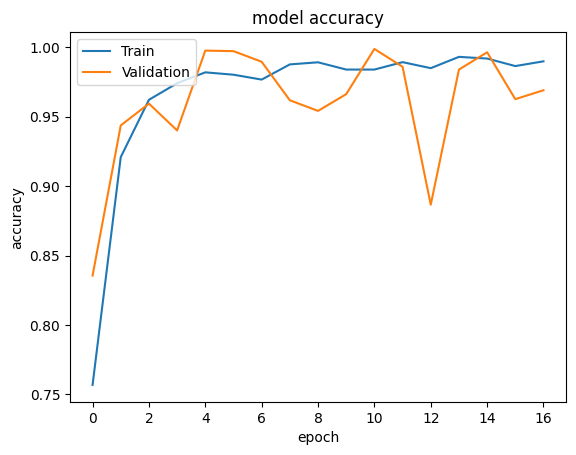

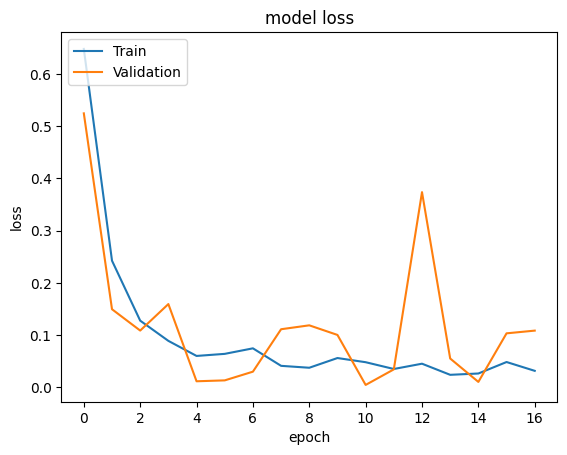

In [21]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()